<a href="https://colab.research.google.com/github/robertostl/Football-Prediction/blob/main/MLModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#conexion al drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#librerias necesarias
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#importación de los ficheros
df = pd.read_pickle('/content/drive/My Drive/SD/df_result_h.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 45 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LG           982 non-null    int64  
 1   LGF          982 non-null    int64  
 2   LTP          982 non-null    int64  
 3   LC           982 non-null    int64  
 4   LGL          982 non-null    int64  
 5   LGFL         982 non-null    int64  
 6   LTL          982 non-null    int64  
 7   LTPL         982 non-null    int64  
 8   LCL          982 non-null    int64  
 9   LGU5P        982 non-null    int64  
 10  VG           982 non-null    int64  
 11  VGC          982 non-null    int64  
 12  VGV          982 non-null    int64  
 13  VGCV         982 non-null    int64  
 14  VGU5P        982 non-null    int64  
 15  LG_p         982 non-null    float64
 16  LGF_p        982 non-null    float64
 17  LGC_p        982 non-null    float64
 18  LT_p         982 non-null    float64
 19  LTP_p   

In [25]:
import pandas as pd
import numpy as np
import sys
import os
import xgboost as xgb
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, roc_curve, auc
from sklearn.metrics import matthews_corrcoef, average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFECV, SelectFromModel



variables_info=['Jornada','anyomes','Result_H']
numerical_variables = [var for var in df.columns if (df[var].dtype==int or df[var].dtype==float ) & (var not in variables_info)]
categorical_variables = [var for var in df.columns if (df[var].dtype==object) & (var not in variables_info)]

Y = df.Result_H.astype("float64")
X_train=df[numerical_variables+categorical_variables]

# Define the sizes of the datasets to use in the training
Train_ratio = 0.7
Test_ratio = 0.3

# First Train and Test split
X_train_0, X_test_0, y_train, y_test = train_test_split(df,Y, test_size = Test_ratio, random_state = 1)
X_train = X_train_0[numerical_variables+categorical_variables]
X_test = X_test_0[numerical_variables+categorical_variables]

# Convert the training and testing sets to XGBoost's format
train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test, label=y_test)

In [28]:
# transformer for numerical variables
numeric_transformer = Pipeline(steps=[
                ('imputerNumeric',SimpleImputer(strategy='median')), # If there is a null it fills it with the median
                ('scaler',StandardScaler()) # Scaler
])

# transformer for categorical variables
categorical_transformer = Pipeline(steps=[
                ('imputerCategorical',SimpleImputer(strategy='constant',fill_value='missing')), # If there is a null value, we fill it with a missing
                ('onehot',OneHotEncoder(handle_unknown = 'ignore')) 
])

# join the transformer
preprocessor = ColumnTransformer(transformers=[
                ('transformerNumeric',numeric_transformer, numerical_variables),
                ('transformerCategoric',categorical_transformer, categorical_variables)
]
                ,remainder='passthrough')


Params = {'objective':'binary:logistic',
              'scale_pos_weight' : (len(y_train)-sum(y_train))/sum(y_train),
              'n_jobs':5}
fit_params = {
        "classifier__eval_metric" : ["logloss","error","auc","aucpr"]
        ,"classifier__early_stopping_rounds": 20}
''' ,"classifier__eval_set" : [(X_test, y_test)]
}'''
pipe_model = Pipeline(steps=[
            ('preprocessor',preprocessor),
            ('classifier',xgb.XGBClassifier(**Params)),# , eval_set = [(X_train, y_train),(X_test,y_test)]
])


param_grid = {
                    'classifier__max_depth': [2,3]
                    ,"classifier__learning_rate" : [0.01]
                    ,"classifier__n_estimators": [1000,500]
                    ,"classifier__colsample_bytree": [0.1,0.5,1]
            }


scoring_dict = {'phi': make_scorer(matthews_corrcoef),
                'f1_w': 'f1_weighted'}

print("Creating model to analyze results ...")
grid_search = GridSearchCV(pipe_model,param_grid ,cv=5,scoring="roc_auc", n_jobs = 15, verbose = 3, return_train_score=True)
grid_result=grid_search.fit(X_train, y_train)

print("Model created.")

model = grid_search.best_estimator_

y_pred_train = model.predict_proba(X_train)[:,1]
y_pred_test = model.predict_proba(X_test)[:,1]

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Creating model to analyze results ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Model created.
Best: 0.609809 using {'classifier__colsample_bytree': 0.1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 500}
0.596463 (0.040474) with: {'classifier__colsample_bytree': 0.1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 2, 'classifier__n_estimators': 1000}
0.596568 (0.038480) with: {'classifier__colsample_bytree': 0.1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 2, 'classifier__n_estimators': 500}
0.605690 (0.034193) with: {'classifier__colsample_bytree': 0.1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 1000}
0.609809 (0.030121) with: {'classifier__colsample_bytree': 0.1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 500}
0.592920 (0.030409) with: {'classifier__colsample_bytree': 0.5, 'classifier__learning_rat

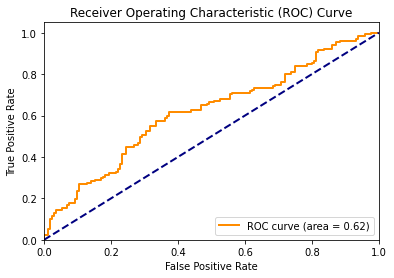

In [17]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Compute the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

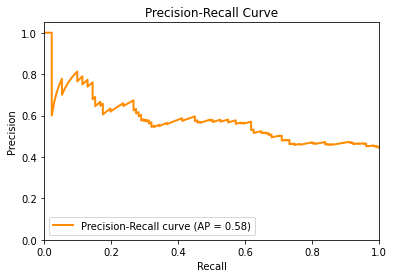

In [18]:
# Compute the precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test)

# Compute the average precision (AP)
ap = average_precision_score(y_test, y_pred_test)

# Plot the precision-recall curve
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (AP = %0.2f)' % ap)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [20]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 13.5 MB/s eta 0:00:00


In [30]:
import shap
#load JS vis in the notebook
shap.initjs() 

#set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(model['classifier'])

#apply the preprocessing to x_test
observations = model['preprocessor'].transform(X_train)
#get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

# Get the feature names
feature_names = X_train.columns



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


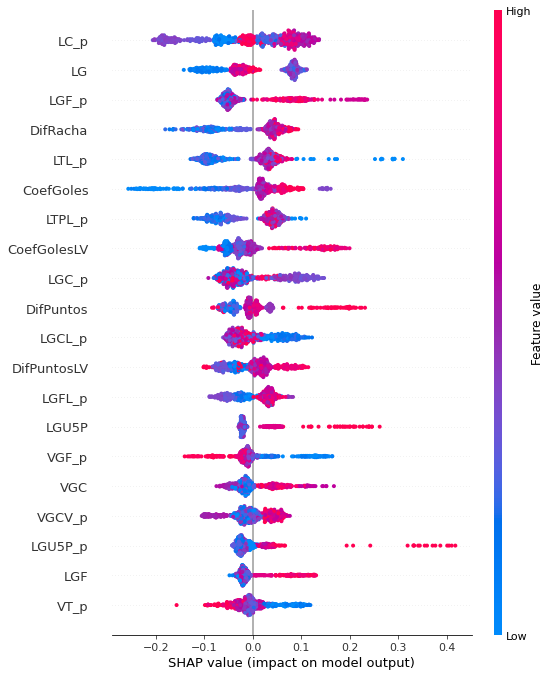

In [31]:
#PLOTS
shap.summary_plot(shap_values, observations, feature_names=feature_names)

In [32]:
feature_importance=pd.DataFrame()
feature_importance['name']=feature_names
feature_importance['value']=model['classifier'].feature_importances_
feature_importance['SHAP']=shap_values[0]
feature_importance

,name,value,SHAP
0,LG,0.026143,0.078631
1,LGF,0.024476,-0.013731
2,LTP,0.022018,0.019225
3,LC,0.018632,-0.017405
4,LGL,0.024192,-0.017973
5,LGFL,0.024971,0.054101
6,LTL,0.019995,0.038751
7,LTPL,0.022958,0.025438
8,LCL,0.021207,0.038290
9,LGU5P,0.029982,-0.015657
